In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
plt.style.use('ggplot')

/usr/local/Caskroom/miniconda/base/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,) ,(0.3081,))])

batch_size = 4

trainset = torchvision.datasets.MNIST(root='../mnist_data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='../mnist_data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [3]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


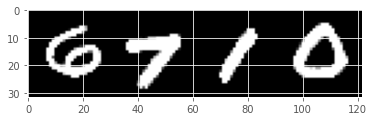

6 7 1 0


In [5]:
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{labels[j]}' for j in range(batch_size)))

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        self.out = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        print('input x size', x.size())
        x = self.conv1(x)
        x = self.conv2(x)
        print('x size before view', x.size())
        x = x.view(x.size(0), -1)
        print('x size after view', x.size())
        return
        output = self.out(x)
        return output

In [7]:
model = CNN()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [9]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.340
[1,  4000] loss: 0.127
[1,  6000] loss: 0.090
[1,  8000] loss: 0.078
[1, 10000] loss: 0.069
[1, 12000] loss: 0.070
[1, 14000] loss: 0.060
[2,  2000] loss: 0.041
[2,  4000] loss: 0.044
[2,  6000] loss: 0.053
[2,  8000] loss: 0.046
[2, 10000] loss: 0.038
[2, 12000] loss: 0.050
[2, 14000] loss: 0.049
Finished Training


In [10]:
PATH = '../mnist_net.pth'
# torch.save(model.state_dict(), PATH)

In [11]:
model = CNN()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 98 %


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


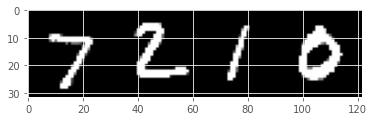

GroundTruth:  7 2 1 0


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{labels[j]}' for j in range(4)))

# First Order Saliency Mapping

## MNIST Example

In [14]:
def compute_saliency_map(X, y, model):

    for param in model.parameters():
        param.requires_grad = False
    
    model.eval()
    X_var = Variable(X.unsqueeze(0), requires_grad=True)
    y_var = Variable(y)

    scores = F.softmax(model(X_var), dim=1)
    grad_scores = scores[0, y.item()]
    grad_scores.backward()

    
    images_grads = X_var.grad.data
    abs_images_grads = images_grads.abs()
    saliency = abs_images_grads.norm(p=2, dim=1) # can be max, or mean, or norm with any p. euclidean norm for p =2
    saliency = (saliency-saliency.min())/(saliency.max()-saliency.min())
    return saliency

In [15]:
def show_saliency_maps(X, y, model):

    X_tensor = X
    y_tensor = torch.LongTensor(y)
    saliencies = np.zeros(shape = (*X.squeeze(0).size(), *y.size()))
    
    for i, label in enumerate(y):
        saliencies[:,:, i] = compute_saliency_map(X_tensor, label, model).squeeze(0).numpy()

    N = y.size()[0]
    fig, axes = plt.subplots(2, N, sharex=True, sharey=True, figsize=(20,15))
    for i, label in enumerate(y):
        axes[0, i].imshow(np.transpose(X.detach().numpy(), (1, 2, 0)))
        axes[0, i].axis('off')
        axes[0,i].grid('false')
        axes[0, i].set_title(f'class {label.item()} pred')
        vals = axes[1, i].imshow(saliencies[:,:, i], cmap=plt.cm.jet)
        axes[1, i].axis('off')
        axes[1,i].grid('false')
        fig.colorbar(vals, ax = axes[1, i], shrink=0.25)
    fig.tight_layout(h_pad=-35, w_pad=0.25)

    plt.show()

/var/folders/fg/phn6mbl962j_g8mhk_kh0syc0000gn/T/ipykernel_27919/4066513481.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(vals, ax = axes[1, i], shrink=0.25)


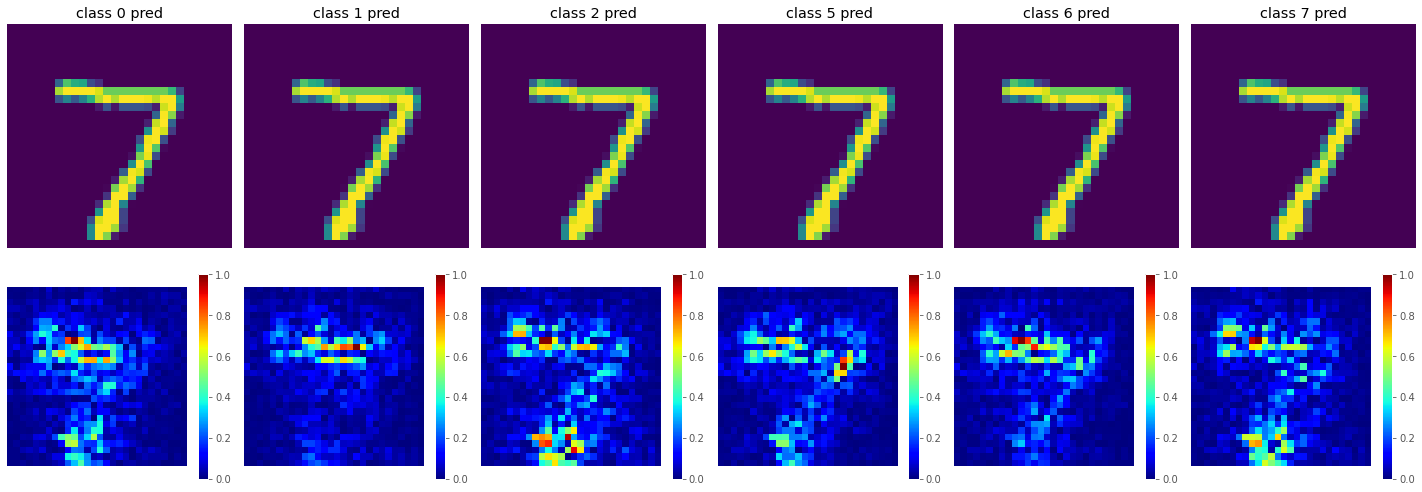

In [16]:
show_saliency_maps(images[0], torch.tensor([0, 1, 2, 5, 6, 7]), model)

## TextCNN Example

In [17]:
from models.CNN_classifier import TextCNN
from data.preprocess import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


In [18]:
params = {
    'emb_dim':  300,
    'num_channels': 100,
    'kernel_size': [2, 3, 4, 5],
    'num_classes': 4,
    'epochs': 15,
    'lr': 0.0001,
    'batch_size': 64,
    'dropout': 0.05
}

ag_news = Dataset()
label_dict = {0 : 'World',
1 : 'Sports',
2 : 'Business',
3 : 'Sci/Tec'}
txtCNN = TextCNN(word_embeddings=ag_news.pretrained_embeds,
                vocab_size=ag_news.vocab_size, params=params)

In [19]:
txtCNN.load_state_dict(torch.load('./weights/txtCNN-07-03'))

<All keys matched successfully>

In [20]:
def generate_batch(data_batch):
    label_batch, text_batch = [], []
    for (l_item, t_item) in data_batch:
        label_batch.append(l_item)
        text_batch.append(torch.cat(
            [torch.tensor([ag_news.bos_index]), t_item, torch.tensor([ag_news.eos_index])], dim=0))
    text_batch = pad_sequence(text_batch, padding_value=ag_news.pad_index)
    label_batch = torch.tensor(label_batch, dtype=torch.int64)
    return label_batch, text_batch

train_loader = DataLoader(ag_news.train_data, batch_size=params['batch_size'],
                          shuffle=True, collate_fn=generate_batch)
valid_loader = DataLoader(ag_news.valid_data, batch_size=params['batch_size'],
                          shuffle=True, collate_fn=generate_batch)
test_loader = DataLoader(ag_news.test_data, batch_size=params['batch_size'],
                         shuffle=True, collate_fn=generate_batch)

In [21]:
def evaluate_topk(model, dataloader, topk=1):
    model.eval()
    total_acc, total_count = 0, 0
    with torch.no_grad():
        for idx, (label, text) in enumerate(dataloader):
            predicted_label = F.softmax(model(text), dim=1)
            top_preds, top_idx = predicted_label.topk(k=topk, dim=1)
            for i, k in enumerate(top_idx):
                total_acc += int(label[i] in k)
            total_count += label.size(0)
    return total_acc/total_count

In [22]:
# sanity check, make sure classifer is working
evaluate_topk(txtCNN, test_loader, topk=1)

0.904342105263158

In [173]:
train_iter = iter(train_loader)
labels, texts = train_iter.next()

In [174]:
labels

tensor([3, 0, 3, 2, 0, 2, 2, 0, 1, 1, 2, 2, 3, 3, 1, 3, 0, 1, 3, 2, 0, 3, 1, 2,
        2, 0, 2, 2, 2, 1, 3, 2, 3, 3, 1, 1, 1, 1, 3, 1, 2, 3, 2, 3, 0, 0, 3, 1,
        1, 1, 3, 3, 3, 0, 3, 3, 3, 1, 0, 3, 1, 3, 0, 1])

In [163]:
texts[:, 5]

tensor([    2,  1304,  1307,    64, 20217, 20812,  2289, 22148,     6, 17618,
         1304,    10,     9,  3773,  2199, 11275,    42,  3639,   545,   911,
         2289,     0, 33909,   138,   102,     6, 45317,  2004,     8, 39324,
          545,  1021,     0, 22148,  1304,   110,    20, 15017,     4,     3,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1, 

In [214]:
t = ''
for i in texts[:, 0].numpy():
    t += ' '+ag_news.vocab.vocab.get_itos()[i]
print(t)

 <bos> ibm and amd partnership extended through 2008 amd and ibm have extended their cpu technology agreement through the end of 2008 . originally signed in december 2002 <unk> the alliance was originally slated to wind up at the end of 2005 . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


## potential sentences

_post ipo google <unk> skeptics scoffed <unk> the securities exchange commission had a fit <unk> and the company had to halve the number of shares of the initial public offering to set a price that valued the company at roughly 120 times earnings <unk> extravagant even by dot . com era standards ._


In [32]:
def compute_text_saliency_map(X, y, model):

    for param in model.parameters():
        param.requires_grad = False
    
    model.eval()
    
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y)

    scores = F.softmax(model.forward2(X_var.unsqueeze(1).permute(1, 2, 0)), dim=1)
    grad_scores = scores[0, y.item()]
    grad_scores.backward()

    
    images_grads = X_var.grad.data
    abs_text_grads = images_grads.abs()
    saliency = abs_text_grads.norm(p=2, dim=1) # can be max, or mean, or norm with any p. euclidean norm for p =2
    saliency = (saliency-saliency.min())/(saliency.max()-saliency.min())

    return saliency

In [31]:
def compute_text_saliency_map_grad(X, y, model):

    for param in model.parameters():
        param.requires_grad = False
    
    model.eval()
    
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y)

    scores = F.softmax(model.forward2(X_var.unsqueeze(1).permute(1, 2, 0)), dim=1)
    grad_scores = scores[0, y.item()]
    first_derivative = torch.autograd.grad(grad_scores, X_var)[0]

    
    images_grads = first_derivative
    abs_text_grads = images_grads.abs()
    saliency = abs_text_grads.norm(p=2, dim=1) # can be max, or mean, or norm with any p. euclidean norm for p =2
    saliency = (saliency-saliency.min())/(saliency.max()-saliency.min())

    return saliency

In [29]:
def show_text_saliency_maps(X, y, dataset, correct_label, label_dict, model):

    X_emb = model.embedding(X)
    predicted_class = F.softmax(model(X.unsqueeze(1)), dim=1).argmax()
    print(f'The predicted class is: {label_dict[predicted_class.item()]}, the correct class is: {label_dict[correct_label.item()]}')
    y_tensor = torch.LongTensor(y)
    saliencies = np.zeros(shape = (X_emb.shape[0], *y.size()))
    
    for i, label in enumerate(y):
        saliencies[:, i] = compute_text_saliency_map_grad(X_emb, label, model).squeeze(0).numpy()
        
    detoked = np.array([dataset.vocab.vocab.get_itos()[tok] for tok in X.numpy()])
    N = y.size()[0]
    pad_idx = np.min(np.where(detoked == '<pad>')[0])
    x_ticks = np.arange(pad_idx+1)
    fig, axes = plt.subplots(N, 1, sharex=False, sharey=False, figsize=(8,60))
    for i, label in enumerate(y):
        axes[i].plot(saliencies[:pad_idx+1, i], x_ticks, '-o')
        # axes[i].set_xticklabels(np.linspace(start=0, stop=saliencies[:, i].max(), num=10))
        axes[i].set_yticks(ticks=x_ticks, labels=detoked[:pad_idx+1])
        axes[i].set_title(f'class \'{label_dict[label.item()]}\' prediction')
        axes[i].invert_yaxis()
    plt.show()

The predicted class is: Business, the correct class is: Business


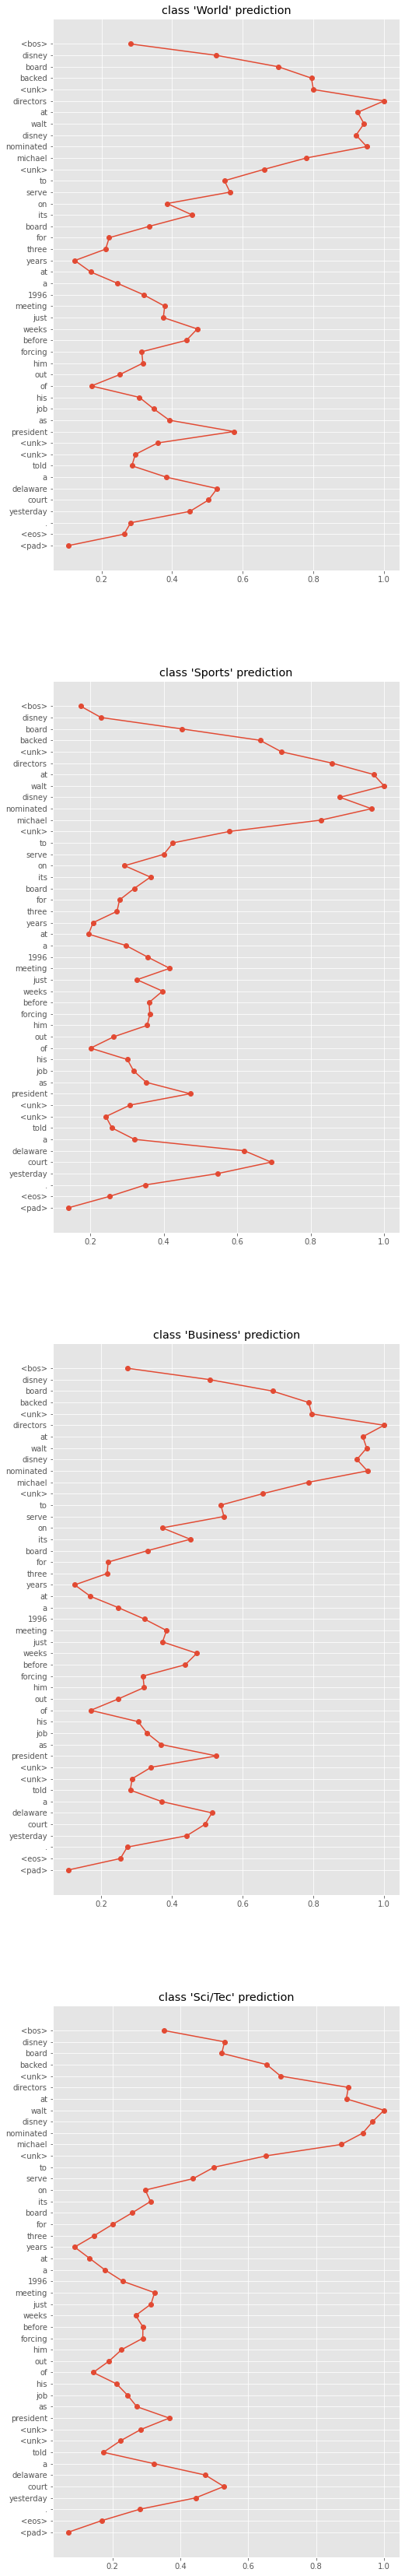

In [33]:
data_sample = 5
show_text_saliency_maps(texts[:,  data_sample], torch.tensor([0, 1, 2, 3]), ag_news, labels[data_sample], label_dict, txtCNN)

In [125]:
def compute_text_saliency_map_Hess(X, y, model):

    for param in model.parameters():
        param.requires_grad = False
    
    model.eval()
    
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y)

    scores = F.softmax(model.forward2(X_var.unsqueeze(1).permute(1, 2, 0)), dim=1)
    grad_scores = scores[0, y.item()]
    
    first_derivative = torch.autograd.grad(grad_scores, X_var)[0]
    
    #get noisy results
    scale_fac=10**(-6)
    noise_tensor=scale_fac*torch.ones(X.shape[0], X.shape[1]) 
    X_noise=X+noise_tensor
    
    X_var_noise=Variable(X_noise, requires_grad=True)
    
    scores_noise = F.softmax(model.forward2(X_var_noise.unsqueeze(1).permute(1, 2, 0)), dim=1)
    grad_scores_noise = scores_noise[0, y.item()]
    
    first_derivative_noise=torch.autograd.grad(grad_scores_noise, X_var_noise)[0]
    
    
    images_grads=(first_derivative_noise-first_derivative)/noise_tensor # Euler approximation of gradient
    
    abs_text_grads = images_grads.abs()
    saliency = abs_text_grads.norm(p=2, dim=1) # can be max, or mean, or norm with any p. euclidean norm for p =2

    return saliency

In [227]:
def show_text_saliency_maps_Hess(X, y, dataset, correct_label, label_dict, model):

    X_emb = model.embedding(X)
    
    predicted_class = F.softmax(model(X.unsqueeze(1)), dim=1)
    print(f'The predicted class is: {label_dict[predicted_class.argmax().item()]}, the correct class is: {label_dict[correct_label.item()]}')
    y_tensor = torch.LongTensor(y)
    saliencies = np.zeros(shape = (X_emb.shape[0], *y.size()))
    saliencies_backward_only = np.zeros(shape = (X_emb.shape[0], *y.size()))
    saliencies_grad_only = np.zeros(shape = (X_emb.shape[0], *y.size()))
    # saliencies_hess_only = np.zeros(shape = (X_emb.shape[0], *y.size()))
    
    for i, label in enumerate(y):
        saliencies_grad = compute_text_saliency_map_grad(X_emb, label, model).squeeze(0).numpy()
        saliencies_Hess = compute_text_saliency_map_Hess(X_emb, label, model).squeeze(0).numpy()
        saliency_unnorm = saliencies_grad+0.5*saliencies_Hess
        saliencies_norm = (saliency_unnorm-saliency_unnorm.min())/(saliency_unnorm.max()-saliency_unnorm.min())
        saliencies_grad_norm=(saliencies_grad-saliencies_grad.min())/(saliencies_grad.max()-saliencies_grad.min())
        saliencies_hess_norm=(saliencies_Hess-saliencies_Hess.min())/(saliencies_Hess.max()-saliencies_Hess.min())
        
        saliencies[:, i] = saliencies_norm
        saliencies_grad_only[:, i] = saliencies_grad_norm
        # saliencies_hess_only[:,i] = saliencies_hess_norm
        
    detoked = np.array([dataset.vocab.vocab.get_itos()[tok] for tok in X.numpy()])
    N = y.size()[0]
    pad_idx = np.min(np.where(detoked == '<pad>')[0])
    x_ticks = np.arange(pad_idx+1)
    fig, axes = plt.subplots(1, N, sharex=False, sharey=False, figsize=(75, 30))
    for i, label in enumerate(y):
        axes[i].plot(saliencies[:pad_idx+1, i], x_ticks, '-o', label='Second Order')
        axes[i].plot(saliencies_grad_only[:pad_idx+1, i], x_ticks, linestyle='dashed', marker='*', label='First Order')
        # axes[i].plot(saliencies_hess_only[:pad_idx+1, i], x_ticks, '-*', label='Harmonic')

        axes[i].set_yticks(ticks=x_ticks)
        axes[i].set_yticklabels(labels=detoked[:pad_idx+1], fontsize=30)
        axes[i].tick_params(axis='x', labelsize=30)
        axes[i].set_title(f'class \'{label_dict[label.item()]}\' prediction: {predicted_class[0, i].item():.3f}', fontsize=30)
        axes[i].invert_yaxis()
        axes[i].legend()
    plt.show()
    fig.savefig('2ndsal')

The predicted class is: Sci/Tec, the correct class is: Sci/Tec


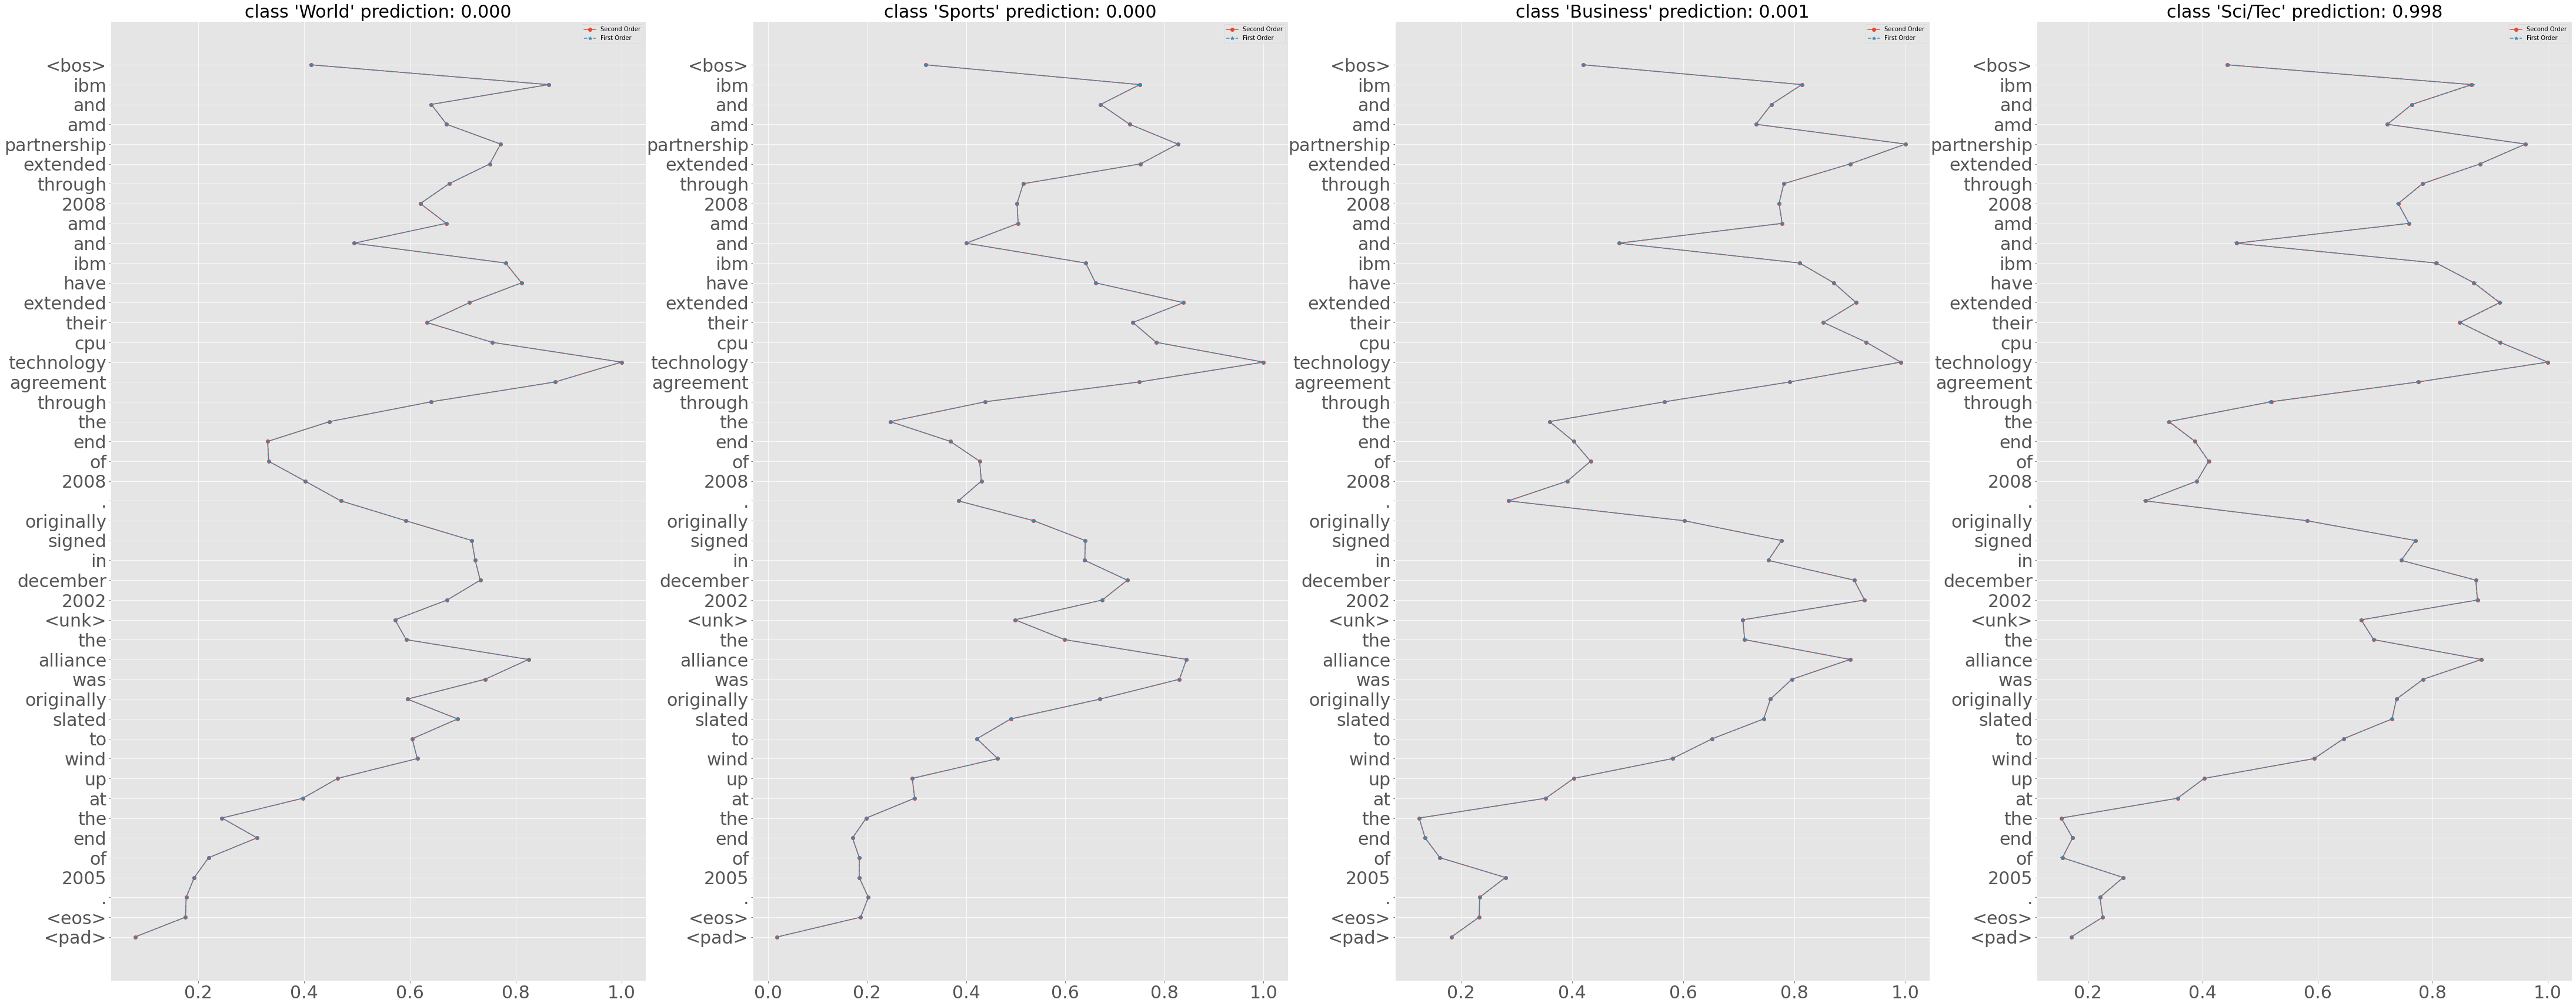

In [228]:
data_sample = 0
show_text_saliency_maps_Hess(texts[:,  data_sample], torch.tensor([0, 1, 2, 3]), ag_news, labels[data_sample], label_dict, txtCNN)